# Train DL

> A collection of deep learning tools via Fastai

In [ ]:
#| default_exp dl

In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
from fastbook import *
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr,pearsonr
from katlas.core import *
from katlas.feature import *
from sklearn.model_selection import *
from torchsummary import summary
import torch.nn.init as init
from katlas.train import *

In [ ]:
#| export
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything()

## Dataset

In [ ]:
#| export
class GeneralDataset:
    def __init__(self, 
                 df, # a dataframe of values
                 feat_col, # feature columns
                 target_col=None # Will return test set for prediction if target col is None
                ):
        "A general dataset that can be applied to any dataframe"
        
        self.test = False if target_col is not None else True
        
        self.X = df[feat_col].values 
        self.y = df[target_col].values if not self.test else None
        
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        X = torch.Tensor(self.X[index])
        if self.test:
            return X
        else:
            y = torch.Tensor(self.y[index])
            return X, y

In [ ]:
df = pd.read_parquet('train/scaled_t5.parquet')

In [ ]:
feat_col = df.columns[199:]
target_col = df.columns[1:199]

In [ ]:
info = Data.get_kinase_info_full()
info = info.query('in_paper ==1')
info = df[['kinase']].merge(info,'left')

In [ ]:
#| output: False
splits = get_splits(info, stratified = 'category')
split = splits[0]

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
# kinase category in train set: 39
# kinase category in test set: 31
---------------------------
# kinase in train set: 243
---------------------------
# kinase in test set: 60
---------------------------
test set: ['BMPR1B' 'CDK5' 'CDK7' 'CDK9' 'CK1G2' 'CK1G3' 'GRK7' 'MAK' 'MOK' 'NEK5' 'NEK9' 'P38B' 'P38D' 'P38G' 'PAK2' 'PAK3' 'PDHK4' 'PIM1' 'PIM3' 'PINK1' 'PKCT' 'PKCZ' 'PKN1' 'PKN3' 'PKR' 'PLK3' 'PRKD2'
 'PRKD3' 'PRKX' 'PRP4' 'PRPK' 'RSK3' 'RSK4' 'SBK' 'SGK1' 'SGK3' 'SIK' 'SKMLCK' 'SMG1' 'SMMLCK' 'SRPK3' 'STLK3' 'TAK1' 'TAO2' 'TAO3' 'TBK1' 'TGFBR1' 'TLK2' 'TNIK' 'TSSK2' 'TTK' 'ULK2' 'VRK1' 'VRK2'
 'WNK1' 'WNK3' 'WNK4' 'YSK1' 'YSK4' 'ZAK']


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
train = df.loc[split[0]]
valid = df.loc[split[1]]

In [ ]:
train.shape, valid.shape

((242, 1223), (61, 1223))

In [ ]:
train_ds = GeneralDataset(train, feat_col, target_col)
valid_ds = GeneralDataset(valid, feat_col, target_col)

In [ ]:
len(train_ds),len(valid_ds)

(242, 61)

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, num_workers=4,bs=32)

In [ ]:
for batch in dls.train: # or dls.valid
    break

In [ ]:
batch[0].shape, batch[1].shape

(torch.Size([32, 1024]), torch.Size([32, 198]))

## Models

### Multi layer perceptron

In [ ]:
#| export
def MLP_1(num_features, 
          num_targets,
          dp = 0.2):
    model = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(dp),
        nn.PReLU(),
        nn.Linear(512, 218),
        nn.BatchNorm1d(218),
        nn.Dropout(dp),
        nn.PReLU(),
        nn.Linear(218, num_targets)
    )
    return model

In [ ]:
num_feat = len(feat_col)
num_target = len(target_col)

In [ ]:
model = MLP_1(num_feat, num_target)

In [ ]:
model(batch[0]).shape

torch.Size([32, 198])

In [ ]:
# To train
# learn = Learner(dls.cuda(), model.cuda(), mse)

# learn.fit_one_cycle(5)

### CNN1D

In [ ]:
#| export
class CNN1D_1(Module):
    
    def __init__(self, 
                 num_features, # this does not matter, just for format
                 num_targets):

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(in_features = int(8 * num_features/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_targets)

    def forward(self, x):
        x = x.unsqueeze(1) # need shape (bs, 1, num_features) for CNN
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        # x = torch.flatten(x, 1)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN1D_1(num_feat, num_target)

In [ ]:
model(batch[0]).shape

torch.Size([32, 198])

In [ ]:
#| export
#| hide
def ConvBlock(in_channels, 
              out_channels, 
              kernel_size, 
              stride, 
              padding, 
              dropout_rate):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Dropout(dropout_rate),
        nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)),
        nn.ReLU()
    )

In [ ]:
#| export
class CNN1D_2(Module):
    
    def __init__(self, 
                 num_features, 
                 num_targets, 
                 hidden_size=4096):

        cha_1 = 256
        cha_2 = 512
        cha_3 = 512

        cha_1_reshape = int(hidden_size/cha_1)
        cha_po_1 = int(hidden_size/cha_1/2)
        cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3

        self.cha_1 = cha_1
        self.cha_2 = cha_2
        self.cha_3 = cha_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.1)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

        self.convBlock1 = ConvBlock(cha_1, cha_2, kernel_size=5, stride=1, padding=2, dropout_rate=0.1)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

        self.convBlock2 = ConvBlock(cha_2, cha_2, kernel_size=3, stride=1, padding=1, dropout_rate=0.1)
        self.convBlock3 = ConvBlock(cha_2, cha_2, kernel_size=3, stride=1, padding=1, dropout_rate=0.3)
        self.convBlock4 = ConvBlock(cha_2, cha_3, kernel_size=5, stride=1, padding=2, dropout_rate=0.2)

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
        self.dropout3 = nn.Dropout(0.2)
        self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

        # Manual weights initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm1d): # initialize for clarification
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.dense1(x), alpha=0.06)

        x = x.reshape(x.shape[0],self.cha_1, self.cha_1_reshape)

        x = self.convBlock1(x)

        x = self.ave_po_c1(x)

        x = self.convBlock2(x)
        x_s = x  # Saving for later use

        x = self.convBlock3(x)

        x = self.convBlock4(x)
        x = x * x_s  # Using saved value

        # Max pooling
        x = self.max_po_c2(x)

        # Flatten before final block
        x = self.flt(x)

        # Final block
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)

        return x

In [ ]:
model = CNN1D_2(num_feat, num_target)

In [ ]:
model(batch[0]).shape

torch.Size([32, 198])

## DL Trainer

In [ ]:
#| export
def train_dl(df, 
            feat_col, 
            target_col,
            split, 
            model, 
             bs = 32,
            loss = mse, 
            save = None, # models/name.pth
             params = {'n_epoch': 4} # params in fastai Learner, e.g., lr_max
              ):
    
    train = df.loc[split[0]]
    valid = df.loc[split[1]]
    
    train_ds = GeneralDataset(train, feat_col, target_col)
    valid_ds = GeneralDataset(valid, feat_col, target_col)

    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, num_workers=4)
    
    learn = Learner(dls.cuda(), model.cuda(), loss, metrics= [PearsonCorrCoef(),SpearmanCorrCoef()] )
    
    lr_max = learn.lr_find()
    plt.show()
    plt.close()
    print(lr_max)
    
    if 'lr_max' not in params:
        params['lr_max'] = lr_max
    
    print(f"lr_find is :{lr_max}, params lr is {params['lr_max']}")
    learn.fit_one_cycle(**params)
    
    if save is not None:
        learn.save(save)
    
    return learn

In [ ]:
model = CNN1D_2(num_feat, num_target)

In [ ]:
params = {'n_epoch': 14, 
          'lr_max': 2e-2,
          'cbs': [SaveModelCallback(fname = 'best')] # save best model
         }

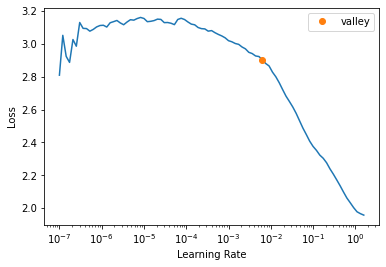

SuggestedLRs(valley=0.0063095735386013985)
lr_find is :SuggestedLRs(valley=0.0063095735386013985), params lr is 0.02


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,2.986260,2.509176,0.157932,0.071554,00:01
1,2.762512,3.209188,-0.021542,0.054468,00:01
2,2.247338,53.745869,0.077133,0.072602,00:01
3,1.867734,4.224357,0.193503,0.148172,00:01
4,1.568677,2.260218,0.223543,0.131413,00:01
5,1.347884,1.214034,0.364480,0.255863,00:01
6,1.181555,0.967572,0.424746,0.397968,00:01
7,1.044163,0.912515,0.472485,0.431782,00:01
8,0.931120,0.811901,0.555741,0.474616,00:01
9,0.838246,0.672877,0.667926,0.537536,00:01


Better model found at epoch 0 with valid_loss value: 2.509176254272461.
Better model found at epoch 4 with valid_loss value: 2.260218381881714.
Better model found at epoch 5 with valid_loss value: 1.214033842086792.
Better model found at epoch 6 with valid_loss value: 0.9675721526145935.
Better model found at epoch 7 with valid_loss value: 0.9125151038169861.
Better model found at epoch 8 with valid_loss value: 0.8119013905525208.
Better model found at epoch 9 with valid_loss value: 0.6728765964508057.
Better model found at epoch 10 with valid_loss value: 0.6020862460136414.
Better model found at epoch 11 with valid_loss value: 0.5698563456535339.
Better model found at epoch 12 with valid_loss value: 0.5634139180183411.


<fastai.learner.Learner>

In [ ]:
learn = train_dl(df,feat_col,target_col, split, model, save = 'final', params = params)

## DL Predict

In [ ]:
#| export
def predict_dl(df, 
               feat_col, 
               model, # model architecture
               model_pth, # only name, not with .pth
              ):
    test_dset = GeneralDataset(df,feat_col)
    test_dl = torch.utils.data.DataLoader(test_dset)
    
    
    learn = Learner(None, model.cuda(), loss_func=1)
    learn.load(model_pth)
    
    learn.model.eval()
    
    preds = []
    for data in test_dl:
        inputs = data.cuda()
        outputs = learn.model(inputs) #learn.model(x).sigmoid().detach().cpu().numpy()

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)
    preds = pd.DataFrame(preds)

    return preds

In [ ]:
pred = predict_dl(df,feat_col,model,'best')

In [ ]:
target = df[target_col]

In [ ]:
target = pd.DataFrame(target.values)

In [ ]:
score_all(target,pred)

rmse is 0.5860
Spearman correlation coefficient: 0.7026
Pearson correlation coefficient: 0.8421 


In [ ]:
score_each(target,pred).head()

average spearman for each row is 0.6975497037952502
average pearson for each row is 0.7474932561753302


,spearman,pearson
0,0.314564,0.317708
1,0.798602,0.875232
2,0.745808,0.858847
3,0.873243,0.966821
4,0.831132,0.908157


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()